<a href="https://colab.research.google.com/github/MehrdadJalali-AI/GraphDBSCAN/blob/main/GraphDBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading dblp dataset...
Original Graph: 317080 nodes, 1049866 edges
Sampled Graph: 1000 nodes, 3232 edges


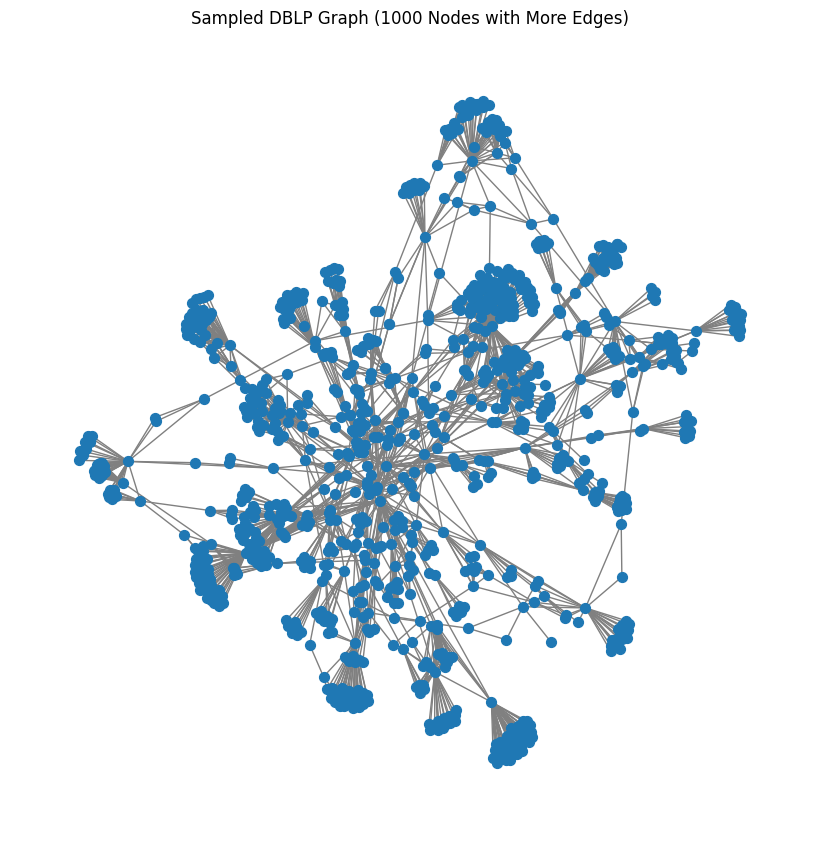


Social Network Analysis Metrics:
Density: 0.0065
Average Degree: 6.4640
Average Betweenness: 0.0037
Average Closeness: 0.2138
Detected 2 communities.


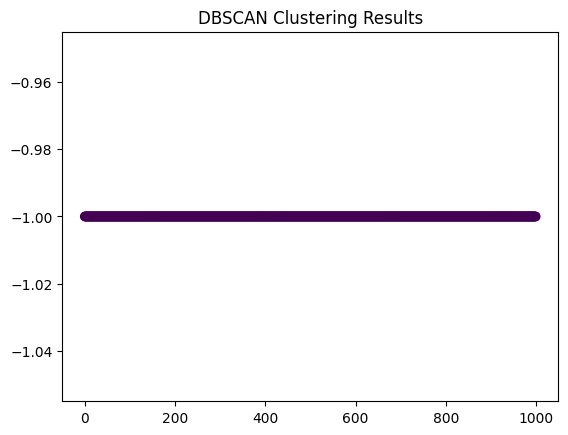

In [7]:
import math
import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community import girvan_newman, greedy_modularity_communities
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KernelDensity
import random
import gzip
from urllib.request import urlretrieve
from collections import deque

# Install required dependencies in Colab
try:
    import google.colab
    !pip install networkx scikit-learn matplotlib
except ImportError:
    pass  # Not in Colab

# Function to download datasets
def download_dataset(url, filename):
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        urlretrieve(url, filename)

# Load dataset from SNAP (YouTube, DBLP, Amazon) and sample 1000 nodes with more edges
def load_graph(dataset_name):
    dataset_urls = {
        "dblp": "https://snap.stanford.edu/data/bigdata/communities/com-dblp.ungraph.txt.gz",
        "amazon": "https://snap.stanford.edu/data/bigdata/communities/com-amazon.ungraph.txt.gz",
        "youtube": "https://snap.stanford.edu/data/bigdata/communities/com-youtube.ungraph.txt.gz",
    }

    if dataset_name not in dataset_urls:
        raise ValueError("Invalid dataset name. Choose from 'dblp', 'amazon', 'youtube'")

    dataset_path = dataset_name + ".txt.gz"

    download_dataset(dataset_urls[dataset_name], dataset_path)

    print(f"Loading {dataset_name} dataset...")
    G = nx.Graph()
    with gzip.open(dataset_path, 'rt') as f:
        for line in f:
            if line.startswith("#"):  # Skip comments
                continue
            node1, node2 = line.strip().split()
            G.add_edge(int(node1), int(node2))

    print(f"Original Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    # Sample 1000 nodes while keeping edges intact using BFS expansion
    seed_node = random.choice(list(G.nodes()))
    sampled_nodes = set()
    queue = deque([seed_node])
    while queue and len(sampled_nodes) < 1000:
        node = queue.popleft()
        if node not in sampled_nodes:
            sampled_nodes.add(node)
            queue.extend(G.neighbors(node))  # Expand BFS

    G_sampled = G.subgraph(sampled_nodes).copy()

    print(f"Sampled Graph: {G_sampled.number_of_nodes()} nodes, {G_sampled.number_of_edges()} edges")
    return G_sampled

# Function to plot community graph
def plot_community_graph(G, title):
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=50, with_labels=False, edge_color='gray')
    plt.title(title)
    plt.show()

# Function for Social Network Analysis (SNA) metrics
def calculate_sna_metrics(G):
    density = nx.density(G)
    avg_degree = sum(dict(G.degree()).values()) / len(G.nodes())
    betweenness = nx.betweenness_centrality(G)
    avg_betweenness = sum(betweenness.values()) / len(G.nodes())
    closeness = nx.closeness_centrality(G)
    avg_closeness = sum(closeness.values()) / len(G.nodes())

    print("\nSocial Network Analysis Metrics:")
    print(f"Density: {density:.4f}")
    print(f"Average Degree: {avg_degree:.4f}")
    print(f"Average Betweenness: {avg_betweenness:.4f}")
    print(f"Average Closeness: {avg_closeness:.4f}")

    return density, avg_degree, avg_betweenness, avg_closeness

# Function for DBSCAN clustering
def dbscan_clustering(G, eps=0.5, min_samples=5):
    X = np.array(list(G.nodes())).reshape(-1, 1)  # Convert nodes to numerical array
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    return clustering.labels_

# Function for Community Detection using Girvan-Newman
def detect_communities_gn(G):
    communities = next(girvan_newman(G))
    communities = [list(c) for c in communities]
    print(f"Detected {len(communities)} communities.")
    return communities

# Load DBLP dataset as an example
G = load_graph("dblp")
plot_community_graph(G, "Sampled DBLP Graph (1000 Nodes with More Edges)")

# Compute SNA Metrics
calculate_sna_metrics(G)

# Detect Communities
communities = detect_communities_gn(G)

# Run DBSCAN clustering
labels = dbscan_clustering(G, eps=0.5, min_samples=10)

# Plot results
plt.scatter(range(len(labels)), labels, c=labels, cmap='viridis')
plt.title("DBSCAN Clustering Results")
plt.show()
